In [1]:
from collections import defaultdict, namedtuple
import sys
import json
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats

In [114]:
phase_dir = '../phased_spark_upd'
ped_file = '../data/spark.ped.quads.ped'
ped_file_orig = '../data/spark.ped'

#phase_dir = '../phased_ssc'
#ped_file = '../data/ssc.ped'
#ped_file_orig = '../data/ssc.ped'
chroms = [str(x) for x in range(1, 23)] + ['X']
family_sizes = [4]
build = '38'

In [115]:
cyto = []
with open('../data/cytoBand%s.txt' % build, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[0].startswith('chr'):
            cyto.append((pieces[0][3:], int(pieces[1]), int(pieces[2]), pieces[3], pieces[4]))

In [116]:
sample_to_affected = dict()
sample_to_sex = dict()

with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        sample_to_affected[pieces[1]] = pieces[5]
        sample_to_sex[pieces[1]] = pieces[4]
        
family_to_inds = defaultdict(set)
with open(ped_file_orig, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        family_to_inds[pieces[0]].add(pieces[1])
        
sample_to_multiplex = dict()
for famkey, inds in family_to_inds.items():
    num_affected = len([x for x in inds if x in sample_to_affected and sample_to_affected[x]=='2'])
    if num_affected>1:
        for ind in inds:
            sample_to_multiplex[ind] = True
    elif num_affected==1:
        for ind in inds:
            sample_to_multiplex[ind] = False


In [117]:
family_to_individuals = dict()
multiplex_pairs, simplex_pairs = set(), set()

# pull families
for j in family_sizes:
    with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, '1', j), 'r') as f:
        next(f) # skip header
        for line in f:
            pieces = line.strip().split('\t')
            family_key = pieces[0]
            individuals = pieces[1:(1+j)]

            family_to_individuals[family_key] = individuals
            
            num_affected = len([x for x in individuals[2:] if sample_to_affected[x]=='2'])
            if num_affected==1:
                if sample_to_multiplex[individuals[2]]:
                    multiplex_pairs.add(tuple(individuals[2:]))
                else:
                    simplex_pairs.add(tuple(individuals[2:]))
            

In [258]:
Recombination = namedtuple('Recombination', ['family', 'chrom', 'start_pos', 'end_pos', 'length',
    'family_size', 'is_mat', 'is_pat', 'children', 'is_masked', 'is_multiplex', 'is_simplex'])
recombinations = []
for chrom in chroms:
    print(chrom)
    # pull phase data for each family

    family_to_states = defaultdict(list)
    family_to_pos = defaultdict(list)
    for family_size in family_sizes:
        with open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, family_size), 'r')  as f:
            next(f) # skip header

            for line in f:
                pieces = line.strip().split('\t')
                family_key = pieces[0]
                state = [int(x) for x in pieces[1:(6+2*family_size)]]
                start_pos, end_pos = [int(x) for x in pieces[(6+2*family_size):(8+2*family_size)]]
                assert end_pos >= start_pos

                family_to_states[family_key].append(state)
                family_to_pos[family_key].append((start_pos, end_pos))
                
    for family_key, states in family_to_states.items():
        states = np.asarray(states)
        positions = np.asarray(family_to_pos[family_key])
        inds = family_to_individuals[family_key]
        m = len(inds)

        # ------------------ Recombinations ---------------------
        # for each child's phase
        for i in range(8, 4+2*m):

            is_mat = i%2==0
            is_pat = i%2==1

            in_recomb = False 
            start_pos, start_index = None, None
            for change_index in np.where((states[:-1, i] != states[1:, i]))[0]:
                if states[change_index, i] != -1 and states[change_index+1, i] != -1:
                    start_pos, end_pos = positions[change_index, 1], positions[change_index+1, 0]
                    assert start_pos <= end_pos
                    is_masked = np.any(states[change_index:(change_index+2), -1]==1)
                    is_multiplex = tuple(inds[2:]) in multiplex_pairs
                    is_simplex = tuple(inds[2:]) in simplex_pairs
                    if is_multiplex or is_simplex:
                        recombinations.append(Recombination(family_key, chrom, 
                                                        start_pos, end_pos, end_pos-start_pos+1,
                                                        family_size, is_mat, is_pat, inds[2:], is_masked,
                                                       is_multiplex, is_simplex))
                    in_recomb = False
                elif in_recomb:
                    assert states[change_index, i] == -1
                    assert start_pos is not None
                    end_pos = positions[change_index+1, 0]
                    assert start_pos <= end_pos
                    is_masked = np.any(states[start_index:(change_index+2), -1]==1)
                    is_multiplex = tuple(inds[2:]) in multiplex_pairs
                    is_simplex = tuple(inds[2:]) in simplex_pairs
                    if is_multiplex or is_simplex:
                        recombinations.append(Recombination(family_key, chrom, 
                                                        start_pos, end_pos, end_pos-start_pos+1,
                                                        family_size, is_mat, is_pat, inds[2:], is_masked,
                                                       is_multiplex, is_simplex))
                    in_recomb = False

                elif not in_recomb:
                    assert states[change_index+1, i] == -1
                    start_pos = positions[change_index, 1]
                    start_index = change_index
                    in_recomb = True
                
            



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
X


In [191]:
N = 500000
hotspot_x, hotspot_starts, hotspot_ends, hotspot_chroms = [], [], [], []
offset = 0
for i, chrom in enumerate(chroms):
    chrom_cyto = [x for x in cyto if x[0] == chrom]
    breakpoints = np.arange(chrom_cyto[0][1], chrom_cyto[-1][2]+N, N)
    print(len(breakpoints))
    #breakpoints = []
    #for c in cyto:
    #    breakpoints.extend(np.arange(c[0], c[1]-N, N).tolist())
    #breakpoints = np.array(breakpoints)

    hotspot_starts.extend(breakpoints[:-1].tolist())
    hotspot_ends.extend(breakpoints[1:].tolist())
    hotspot_chroms.extend([i]*(breakpoints.shape[0]-1))
    hotspot_x.extend((offset + breakpoints[:-1]).tolist())
    offset += breakpoints[-1]
    
hotspot_starts = np.array(hotspot_starts)
hotspot_ends = np.array(hotspot_ends)
hotspot_chroms = np.array(hotspot_chroms)
hotspot_x = np.array(hotspot_x)
print(hotspot_starts.shape, hotspot_ends.shape, hotspot_chroms.shape)

499
486
398
382
365
343
320
292
278
269
272
268
230
216
205
182
168
162
119
130
95
103
314
(6073,) (6073,) (6073,)


In [265]:
control_recombinations = []
with open('../data/Kong2014/DECODE_Recombination_Events_Maternal_01OCT2013.txt', 'r') as f:
    next(f) # skip header
    for line in f:
        pieces = line.strip().split()
        start_pos, end_pos = int(pieces[1]), int(pieces[2])
        control_recombinations.append(Recombination(None, pieces[0][3:],
                                                    start_pos, end_pos, 
                                                    end_pos-start_pos+1,
                                                    None, True, False, inds[2:], False,
                                                   False, False))
with open('../data/Kong2014/DECODE_Recombination_Events_Paternal_01OCT2013.txt', 'r') as f:
    next(f) # skip header
    for line in f:
        pieces = line.strip().split()
        start_pos, end_pos = int(pieces[1]), int(pieces[2])
        control_recombinations.append(Recombination(None, pieces[0][3:],
                                                    start_pos, end_pos, 
                                                    end_pos-start_pos+1,
                                                    None, False, True, inds[2:], False,
                                                   False, False))           

In [275]:
# aff-aff/aff-typ/typ-typ, mat/pat
aff_hotspots = np.zeros((len(hotspot_starts), 3, 2))

# M-M/M-F/F-F, mat/pat
sex_hotspots = np.zeros((len(hotspot_starts), 3, 2))

# simplex/multiplex, mat/pat
plex_hotspots = np.zeros((len(hotspot_starts), 2, 2))

for j, chrom in enumerate(chroms):
    print(chrom)
    chrom_recombinations = [x for x in recombinations if (not x.is_masked) and (x.chrom == chrom)]
    print('chrom', chrom, 'hotspots', np.where(hotspot_chroms==j)[0].shape[0], 'recombinations', len(chrom_recombinations))
    for i in np.where(hotspot_chroms==j)[0]:
        hotspot_start, hotspot_end = hotspot_starts[i], hotspot_ends[i]
        for recomb in chrom_recombinations:
            overlap = min(hotspot_end, recomb.end_pos) - max(hotspot_start, recomb.start_pos)
            assert overlap <= recomb.length
            if overlap > 0:
                num_affected = len([x for x in recomb.children if sample_to_affected[x]=='2'])
                num_F = len([x for x in recomb.children if sample_to_sex[x]=='2'])
                aff_hotspots[i, 2-num_affected, int(recomb.is_pat)] += overlap/recomb.length
                sex_hotspots[i, num_F, int(recomb.is_pat)] += overlap/recomb.length
                plex_hotspots[i, int(recomb.is_multiplex), int(recomb.is_pat)] += overlap/recomb.length
                
                    
        

num_aff_aff = len([v for v in family_to_individuals.values() if sample_to_affected[v[2]]=='2' and sample_to_affected[v[3]]=='2'])
num_aff_typ = len([v for v in family_to_individuals.values() if (sample_to_affected[v[2]]=='2' and sample_to_affected[v[3]]=='1') or (sample_to_affected[v[2]]=='1' and sample_to_affected[v[3]]=='2')])
num_typ_typ = len([v for v in family_to_individuals.values() if sample_to_affected[v[2]]=='1' and sample_to_affected[v[3]]=='1'])
print('aff-aff', num_aff_aff, 'aff-typ', num_aff_typ, 'typ-typ', num_typ_typ)

# normalization
aff_hotspots[:, 0, :] = aff_hotspots[:, 0, :]/(2*num_aff_aff)
aff_hotspots[:, 1, :] = aff_hotspots[:, 1, :]/(2*num_aff_typ)
aff_hotspots[:, 2, :] = aff_hotspots[:, 2, :]/(2*num_typ_typ)

num_F_F = len([v for v in family_to_individuals.values() if sample_to_sex[v[2]]=='2' and sample_to_sex[v[3]]=='2'])
num_M_F = len([v for v in family_to_individuals.values() if (sample_to_sex[v[2]]=='2' and sample_to_sex[v[3]]=='1') or (sample_to_affected[v[2]]=='1' and sample_to_affected[v[3]]=='2')])
num_M_M = len([v for v in family_to_individuals.values() if sample_to_sex[v[2]]=='1' and sample_to_sex[v[3]]=='1'])
print('M-M', num_M_M, 'M-F', num_M_F, 'F-F', num_F_F)

# normalization
sex_hotspots[:, 0, :] = sex_hotspots[:, 0, :]/(2*num_M_M)
sex_hotspots[:, 1, :] = sex_hotspots[:, 1, :]/(2*num_M_F)
sex_hotspots[:, 2, :] = sex_hotspots[:, 2, :]/(2*num_F_F)

# normalization
num_multiplex = len(multiplex_pairs)
num_simplex = len(simplex_pairs)

plex_hotspots[:, 0, :] = plex_hotspots[:, 0, :]/(2*num_simplex)
plex_hotspots[:, 1, :] = plex_hotspots[:, 1, :]/(2*num_multiplex)
print('multiplex', num_multiplex, 'simplex', num_simplex)



1
chrom 1 hotspots 498 recombinations 32571
2
chrom 2 hotspots 485 recombinations 30369
3
chrom 3 hotspots 397 recombinations 26339
4
chrom 4 hotspots 381 recombinations 24645
5
chrom 5 hotspots 364 recombinations 24086
6
chrom 6 hotspots 342 recombinations 22910
7
chrom 7 hotspots 319 recombinations 22137
8
chrom 8 hotspots 291 recombinations 20158
9
chrom 9 hotspots 277 recombinations 19415
10
chrom 10 hotspots 268 recombinations 20451
11
chrom 11 hotspots 271 recombinations 18786
12
chrom 12 hotspots 267 recombinations 20044
13
chrom 13 hotspots 229 recombinations 15537
14
chrom 14 hotspots 215 recombinations 14403
15
chrom 15 hotspots 204 recombinations 14752
16
chrom 16 hotspots 181 recombinations 15791
17
chrom 17 hotspots 167 recombinations 15966
18
chrom 18 hotspots 161 recombinations 14484
19
chrom 19 hotspots 118 recombinations 13271
20
chrom 20 hotspots 129 recombinations 13155
21
chrom 21 hotspots 94 recombinations 7417
22
chrom 22 hotspots 102 recombinations 8611
X
chrom X

In [268]:
control_hotspots = np.zeros((len(hotspot_starts), 2))

for j, chrom in enumerate(chroms):
    print(chrom)
    chrom_recombinations = [x for x in control_recombinations if (not x.is_masked) and (x.chrom == chrom)]
    print('chrom', chrom, 'hotspots', np.where(hotspot_chroms==j)[0].shape[0], 'recombinations', len(chrom_recombinations))
    
    hotspot_indices = np.where(hotspot_chroms==j)[0]
    chrom_breakpoints = hotspot_starts[hotspot_indices]
    recomb_starts = np.array([x.start_pos for x in chrom_recombinations])
    recomb_ends = np.array([x.end_pos for x in chrom_recombinations])
    
    start_indices = np.searchsorted(chrom_breakpoints, recomb_starts)
    end_indices = np.searchsorted(chrom_breakpoints, recomb_ends)
    
    for recomb, start_index, end_index in zip(chrom_recombinations, start_indices, end_indices):
        for i in range(hotspot_indices[start_index], hotspot_indices[end_index]+1):
            hotspot_start, hotspot_end = hotspot_starts[i], hotspot_ends[i]
            overlap = min(hotspot_end, recomb.end_pos) - max(hotspot_start, recomb.start_pos)
            assert overlap <= recomb.length
            if overlap > 0:
                control_hotspots[i, int(recomb.is_pat)] += overlap/recomb.length
                
control_hotspots[:, 0] = control_hotspots[:, 0]/41745
control_hotspots[:, 1] = control_hotspots[:, 1]/30184



1
chrom 1 hotspots 498 recombinations 189574
2
chrom 2 hotspots 485 recombinations 178027
3
chrom 3 hotspots 397 recombinations 149273
4
chrom 4 hotspots 381 recombinations 142761
5
chrom 5 hotspots 364 recombinations 135273
6
chrom 6 hotspots 342 recombinations 124361
7
chrom 7 hotspots 319 recombinations 120161
8
chrom 8 hotspots 291 recombinations 115003
9
chrom 9 hotspots 277 recombinations 98380
10
chrom 10 hotspots 268 recombinations 110937
11
chrom 11 hotspots 271 recombinations 100902
12
chrom 12 hotspots 267 recombinations 103423
13
chrom 13 hotspots 229 recombinations 77904
14
chrom 14 hotspots 215 recombinations 68922
15
chrom 15 hotspots 204 recombinations 76138
16
chrom 16 hotspots 181 recombinations 78590
17
chrom 17 hotspots 167 recombinations 78646
18
chrom 18 hotspots 161 recombinations 69325
19
chrom 19 hotspots 118 recombinations 54945
20
chrom 20 hotspots 129 recombinations 60669
21
chrom 21 hotspots 94 recombinations 29687
22
chrom 22 hotspots 102 recombinations 32

In [260]:
plex_pvalues = np.ones((plex_hotspots.shape[0], 3))
for i in range(plex_hotspots.shape[0]):
    if num_simplex > 0 and num_multiplex > 0:
        plex_pvalues[i, 0] = scipy.stats.fisher_exact([[2*num_simplex*plex_hotspots[i, 0, 0], 2*num_simplex*(1-plex_hotspots[i, 0, 0])], 
                                              [2*num_multiplex*plex_hotspots[i, 1, 0], 2*num_multiplex*(1-plex_hotspots[i, 1, 0])]], alternative='greater')[1]
        plex_pvalues[i, 1] = scipy.stats.fisher_exact([[2*num_simplex*plex_hotspots[i, 0, 1], 2*num_simplex*(1-plex_hotspots[i, 0, 1])], 
                                              [2*num_multiplex*plex_hotspots[i, 1, 1], 2*num_multiplex*(1-plex_hotspots[i, 1, 1])]], alternative='greater')[1]
    
        plex_pvalues[i, 2] = scipy.stats.fisher_exact([[2*num_simplex*np.sum(plex_hotspots[i, 0, :]), 2*num_simplex*(1-np.sum(plex_hotspots[i, 0, :]))], 
                                              [2*num_multiplex*np.sum(plex_hotspots[i, 1, :]), 2*num_multiplex*(1-np.sum(plex_hotspots[i, 1, :]))]], alternative='greater')[1]

aff_pvalues = np.ones((aff_hotspots.shape[0], 3))
for i in range(aff_hotspots.shape[0]):
    if num_aff_aff > 0 and num_aff_typ > 0:
        aff_pvalues[i, 0] = scipy.stats.fisher_exact([[2*num_aff_aff*aff_hotspots[i, 0, 0], 2*num_aff_aff*(1-aff_hotspots[i, 0, 0])], 
                                              [2*num_aff_typ*aff_hotspots[i, 1, 0], 2*num_aff_typ*(1-aff_hotspots[i, 1, 0])]])[1]
    
        aff_pvalues[i, 1] = scipy.stats.fisher_exact([[2*num_aff_aff*aff_hotspots[i, 0, 1], 2*num_aff_aff*(1-aff_hotspots[i, 0, 1])], 
                                              [2*num_aff_typ*aff_hotspots[i, 1, 1], 2*num_aff_typ*(1-aff_hotspots[i, 1, 1])]])[1]
    
        aff_pvalues[i, 2] = scipy.stats.fisher_exact([[2*num_aff_aff*np.sum(aff_hotspots[i, 0, :]), 2*num_aff_aff*(1-np.sum(aff_hotspots[i, 0, :]))], 
                                              [2*num_aff_typ*np.sum(aff_hotspots[i, 1, :]), 2*num_aff_typ*(1-np.sum(aff_hotspots[i, 1, :]))]])[1]

sex_pvalues = np.ones((sex_hotspots.shape[0], 3))
for i in range(sex_hotspots.shape[0]):
    if num_M_M > 0 and num_F_F > 0:
        sex_pvalues[i, 0] = scipy.stats.fisher_exact([[2*num_M_M*sex_hotspots[i, 0, 0], 2*num_M_M*(1-sex_hotspots[i, 0, 0])], 
                                              [2*num_F_F*sex_hotspots[i, 2, 0], 2*num_F_F*(1-sex_hotspots[i, 2, 0])]])[1]
    
        sex_pvalues[i, 1] = scipy.stats.fisher_exact([[2*num_M_M*sex_hotspots[i, 0, 1], 2*num_M_M*(1-sex_hotspots[i, 0, 1])], 
                                              [2*num_F_F*sex_hotspots[i, 2, 1], 2*num_F_F*(1-sex_hotspots[i, 2, 1])]])[1]
    
        sex_pvalues[i, 2] = scipy.stats.fisher_exact([[2*num_M_M*np.sum(sex_hotspots[i, 0, :]), 2*num_M_M*(1-np.sum(sex_hotspots[i, 0, :]))], 
                                              [2*num_F_F*np.sum(sex_hotspots[i, 2, :]), 2*num_F_F*(1-np.sum(sex_hotspots[i, 2, :]))]])[1]
                                              

In [261]:
cutoff = -np.log10(0.05/hotspot_starts.shape[0])


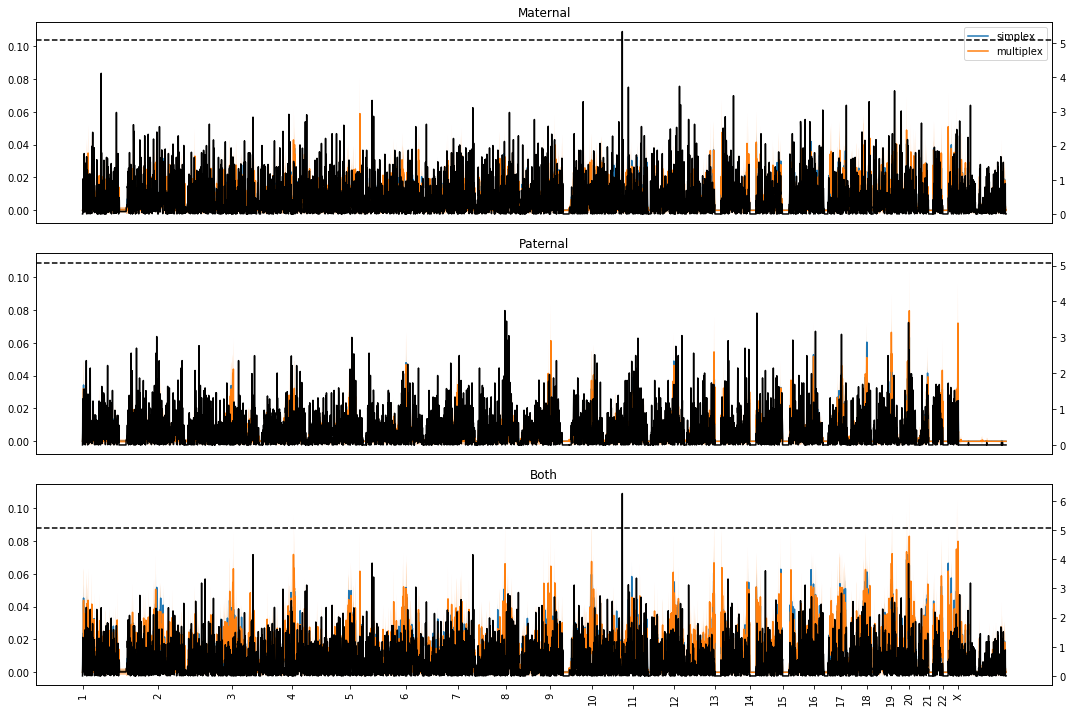

In [273]:

plt.figure(figsize=(15, 10))

def plot_with_conf(p, label, n):
    plt.plot(hotspot_x, p, label=label)
    std = 2*np.sqrt(p*(1-p)/n)
    plt.fill_between(hotspot_x, p-std, p+std, alpha=0.5)
    

ax1 = plt.subplot(3, 1, 1)
if num_simplex > 100:
    plot_with_conf(plex_hotspots[:, 0, 0], 'simplex', num_simplex)
if num_multiplex > 100:
    plot_with_conf(plex_hotspots[:, 1, 0], 'multiplex', num_multiplex)

plt.legend()
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.title('Maternal')

alt_ax1 = ax1.twinx()
alt_ax1.plot(hotspot_x, -np.log10(plex_pvalues[:, 0]), color='black')
alt_ax1.axhline(cutoff, linestyle='--', color='black')

ax2 = plt.subplot(3, 1, 2, sharex=ax1, sharey=ax1)
if num_simplex > 100:
    plot_with_conf(plex_hotspots[:, 0, 1], 'simplex', num_simplex)
if num_multiplex > 100:
    plot_with_conf(plex_hotspots[:, 1, 1], 'multiplex', num_multiplex)
    
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.title('Paternal')

alt_ax2 = ax2.twinx()
alt_ax2.plot(hotspot_x, -np.log10(plex_pvalues[:, 1]), color='black')
alt_ax2.axhline(cutoff, linestyle='--', color='black')


ax3 = plt.subplot(3, 1, 3, sharex=ax1, sharey=ax1)
if num_simplex > 100:
    plot_with_conf(np.sum(plex_hotspots[:, 0, :], axis=1), 'simplex', num_simplex)
if num_multiplex > 100:
    plot_with_conf(np.sum(plex_hotspots[:, 1, :], axis=1), 'multiplex', num_multiplex)

plt.xticks([0] + hotspot_x[:-1][hotspot_chroms[:-1]!=hotspot_chroms[1:]].tolist(), chroms, rotation=90)
plt.title('Both')

alt_ax3 = ax3.twinx()
alt_ax3.plot(hotspot_x, -np.log10(plex_pvalues[:, 2]), color='black')
alt_ax3.axhline(cutoff, linestyle='--', color='black')

plt.tight_layout()
plt.show()

In [263]:
i = np.argmax(-np.log10(plex_pvalues[:, 2]))
print(chroms[hotspot_chroms[i]], hotspot_starts[i], hotspot_ends[i])
print('Mat\tPat')
print(plex_hotspots[i, :, :])

i = np.argmax(-np.log10(plex_pvalues[:, 0]))
print(chroms[hotspot_chroms[i]], hotspot_starts[i], hotspot_ends[i])
print('Mat\tPat')
print(plex_hotspots[i, :, :])

10 97500000 98000000
Mat	Pat
[[0.01482237 0.00242777]
 [0.0011111  0.        ]]
10 97500000 98000000
Mat	Pat
[[0.01482237 0.00242777]
 [0.0011111  0.        ]]


In [247]:
hotspot_start, hotspot_end = hotspot_starts[i-5], hotspot_ends[i+5]
of_interest = [x for x in recombinations if x.chrom == chroms[hotspot_chroms[i]] and min(hotspot_end, x.end_pos) - max(hotspot_start, x.start_pos)>0]

# position, simplex/multiplex, mat/pat
region = np.zeros((hotspot_end-hotspot_start+1, 2, 2))

for recomb in of_interest:
    if tuple(recomb.children) in multiplex_pairs:
        region[(max(hotspot_start, recomb.start_pos)-hotspot_start):(min(hotspot_end, recomb.end_pos)+1-hotspot_start), 1, int(recomb.is_pat)] += 1/recomb.length
    elif tuple(recomb.children) in simplex_pairs:
        region[(max(hotspot_start, recomb.start_pos)-hotspot_start):(min(hotspot_end, recomb.end_pos)+1-hotspot_start), 0, int(recomb.is_pat)] += 1/recomb.length
        
        

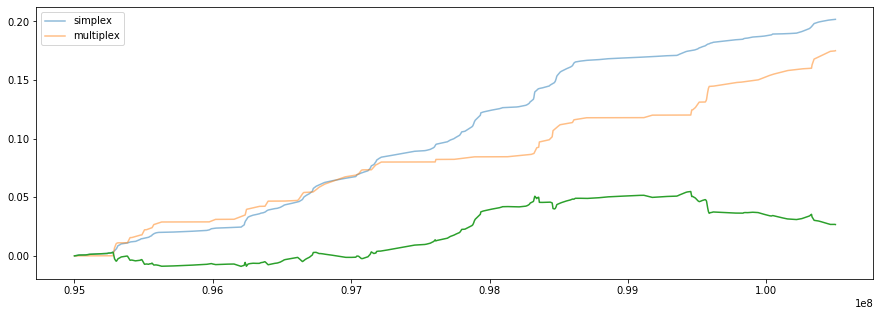

In [256]:
import scipy.signal

plt.figure(figsize=(15, 5))

x = np.arange(hotspot_start, hotspot_end+1)

n = num_simplex
p = (region[:, 0, 0]+region[:, 0, 1])/n
plt.plot(x, np.cumsum(p), label='simplex', alpha=0.5)
std = 2*np.sqrt(p*(1-p)/n)
#plt.fill_between(x, p-std, p+std, alpha=0.5)

n = num_multiplex
q = (region[:, 1, 0]+region[:, 1, 1])/n
plt.plot(x, np.cumsum(q), label='multiplex', alpha=0.5)
std = 2*np.sqrt(q*(1-q)/n)
#plt.fill_between(x, p-std, p+std, alpha=0.5)

plt.plot(x, np.cumsum(p)-np.cumsum(q))

#y = np.sum(region, axis=(1, 2))/(num_simplex+num_multiplex)
#peaks, properties = scipy.signal.find_peaks(y, prominence=10**(-7), width=1000)
#plt.plot(x, y)
#plt.plot(x[peaks], np.zeros(peaks.shape), "x")

plt.legend()
#plt.ylim([0, 10*np.max(p)])
plt.show()

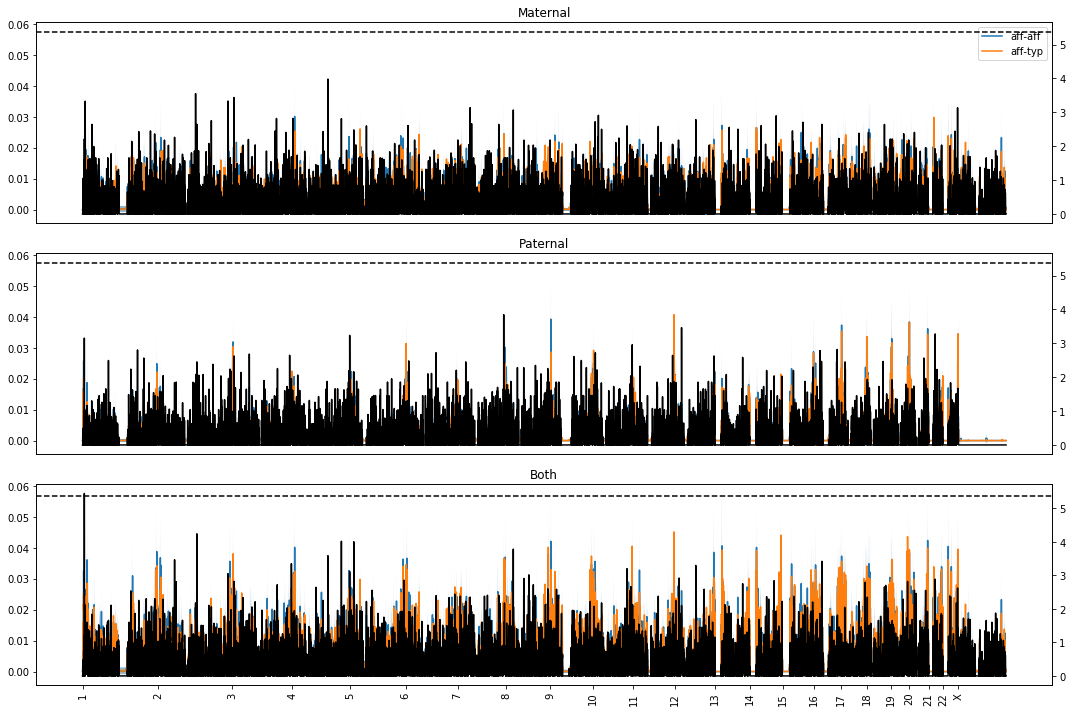

In [188]:

plt.figure(figsize=(15, 10))

ax1 = plt.subplot(3, 1, 1)
if num_aff_aff > 100:
    plot_with_conf(aff_hotspots[:, 0, 0], 'aff-aff', num_aff_aff)
if num_aff_typ > 100:
    plot_with_conf(aff_hotspots[:, 1, 0], 'aff-typ', num_aff_typ)
if num_typ_typ > 100:
    plot_with_conf(aff_hotspots[:, 2, 0], 'typ-typ', num_typ-typ)
    
plt.legend()
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.title('Maternal')

alt_ax1 = ax1.twinx()
alt_ax1.plot(hotspot_x, -np.log10(aff_pvalues[:, 0]), color='black')
alt_ax1.axhline(cutoff, linestyle='--', color='black')

ax2 = plt.subplot(3, 1, 2, sharex=ax1, sharey=ax1)
if num_aff_aff > 100:
    plot_with_conf(aff_hotspots[:, 0, 1], 'aff-aff', num_aff_aff)
if num_aff_typ > 100:
    plot_with_conf(aff_hotspots[:, 1, 1], 'aff-typ', num_aff_typ)
if num_typ_typ > 100:
    plot_with_conf(aff_hotspots[:, 2, 1], 'typ-typ', num_typ-typ)
    
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.title('Paternal')

alt_ax2 = ax2.twinx()
alt_ax2.plot(hotspot_x, -np.log10(aff_pvalues[:, 1]), color='black')
alt_ax2.axhline(cutoff, linestyle='--', color='black')


ax3 = plt.subplot(3, 1, 3, sharex=ax1, sharey=ax1)
if num_aff_aff > 100:
    plot_with_conf(np.sum(aff_hotspots[:, 0, :], axis=1), 'aff-aff', num_aff_aff)
if num_aff_typ > 100:
    plot_with_conf(np.sum(aff_hotspots[:, 1, :], axis=1), 'aff-typ', num_aff_typ)
if num_typ_typ > 100:
    plot_with_conf(np.sum(aff_hotspots[:, 2, :], axis=1), 'typ-typ', num_typ-typ)

plt.xticks([0] + hotspot_x[:-1][hotspot_chroms[:-1]!=hotspot_chroms[1:]].tolist(), chroms, rotation=90)
plt.title('Both')

alt_ax3 = ax3.twinx()
alt_ax3.plot(hotspot_x, -np.log10(aff_pvalues[:, 2]), color='black')
alt_ax3.axhline(cutoff, linestyle='--', color='black')

plt.tight_layout()
plt.show()

In [189]:
i = np.argmax(-np.log10(aff_pvalues[:, 2]))
print(chroms[hotspot_chroms[i]], hotspot_starts[i], hotspot_ends[i])
print('Mat\tPat')
print(aff_hotspots[i, :, :])

1 6000000 6250000
Mat	Pat
[[0.00074638 0.00185433]
 [0.00622079 0.00957782]
 [0.         0.01922805]]


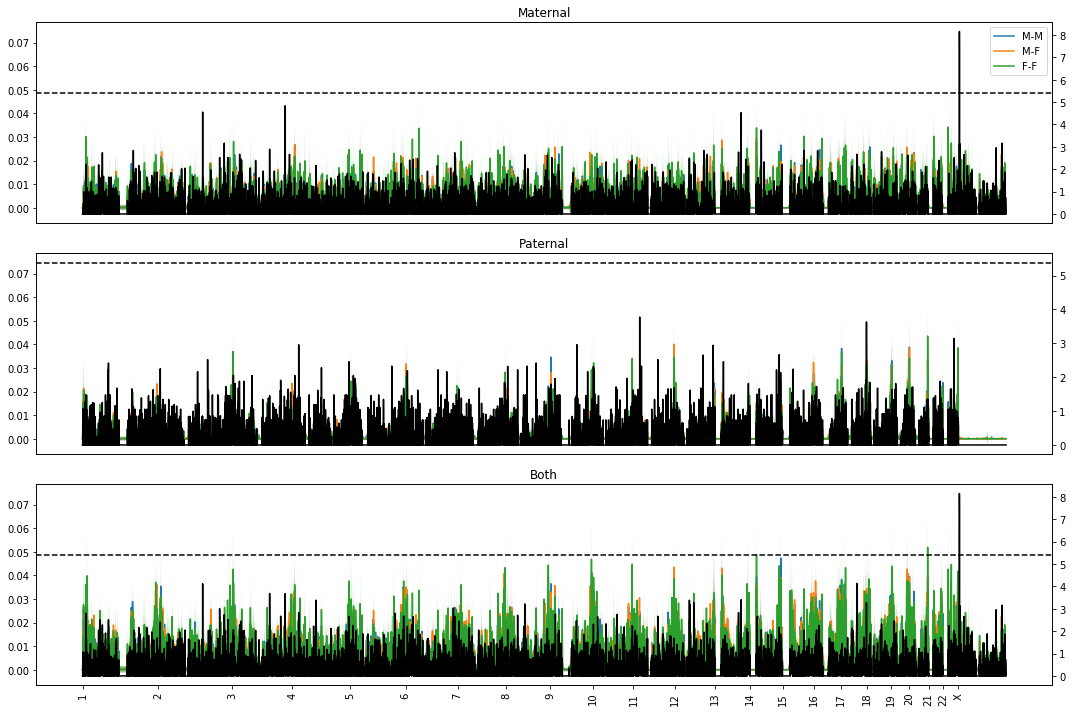

In [190]:
plt.figure(figsize=(15, 10))

ax1 = plt.subplot(3, 1, 1)
if num_M_M > 100:
    plot_with_conf(sex_hotspots[:, 0, 0], 'M-M', num_M_M)
if num_M_F > 100:
    plot_with_conf(sex_hotspots[:, 1, 0], 'M-F', num_M_F)
if num_F_F > 100:
    plot_with_conf(sex_hotspots[:, 2, 0], 'F-F', num_F_F)
    
plt.legend()
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.title('Maternal')

alt_ax1 = ax1.twinx()
alt_ax1.plot(hotspot_x, -np.log10(sex_pvalues[:, 0]), color='black')
alt_ax1.axhline(cutoff, linestyle='--', color='black')

ax2 = plt.subplot(3, 1, 2, sharex=ax1, sharey=ax1)
if num_M_M > 100:
    plot_with_conf(sex_hotspots[:, 0, 1], 'M-M', num_M_M)
if num_M_F > 100:
    plot_with_conf(sex_hotspots[:, 1, 1], 'M-F', num_M_F)
if num_F_F > 100:
    plot_with_conf(sex_hotspots[:, 2, 1], 'F-F', num_F_F)
    
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.title('Paternal')

alt_ax2 = ax2.twinx()
alt_ax2.plot(hotspot_x, -np.log10(sex_pvalues[:, 1]), color='black')
alt_ax2.axhline(cutoff, linestyle='--', color='black')


ax3 = plt.subplot(3, 1, 3, sharex=ax1, sharey=ax1)
if num_M_M > 100:
    plot_with_conf(np.sum(sex_hotspots[:, 0, :], axis=1), 'M_M', num_M_M)
if num_M_F > 100:
    plot_with_conf(np.sum(sex_hotspots[:, 1, :], axis=1), 'M_F', num_M_F)
if num_F_F > 100:
    plot_with_conf(np.sum(sex_hotspots[:, 2, :], axis=1), 'F_F', num_F_F)

plt.xticks([0] + hotspot_x[:-1][hotspot_chroms[:-1]!=hotspot_chroms[1:]].tolist(), chroms, rotation=90)
plt.title('Both')

alt_ax3 = ax3.twinx()
alt_ax3.plot(hotspot_x, -np.log10(sex_pvalues[:, 2]), color='black')
alt_ax3.axhline(cutoff, linestyle='--', color='black')

plt.tight_layout()
plt.show()